In [59]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/mjoppich/.local/lib/python3.6/site-packages', '/home/mjoppich/.local/lib/python3.6/site-packages/mpld3-0.3.1.dev1-py3.6.egg', '/home/mjoppich/.local/lib/python3.6/site-packages/opennre-0.1-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/mnt/d/PythonCGI/jupyter_micropython_kernel', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../', '../']


In [2]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML")

Opening regions file for /mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML


0 356 400 215 273
1 436 478 632 687
2 1572 1612 608 666
3 1149 1197 142 205
4 618 666 211 266
5 633 684 630 688
6 1357 1400 628 686


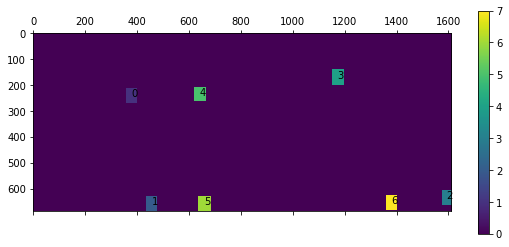

In [3]:
imze.list_regions()

In [4]:
spectra = imze.get_region_array(0, makeNullLine=True)
imze.normalize_region_array(spectra, normalize="vector")


Found region 0 with shape (45, 59, 17900)
I0615 23:41:42.488585 140009190655808 segment.py:1906] Found region 0 with shape (45, 59, 17900)


3454.87441091502 39
3456.383544128344 278
3457.8926773416683 2332
14981.633894285647 2
14980.124761072322 2
4965.516757452595 2


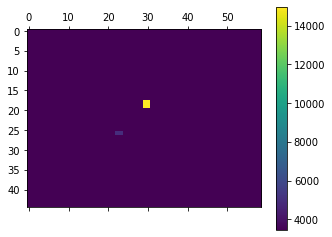

2655 0.082599886 1.0 0.3578650971843024


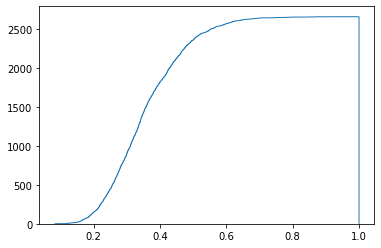

In [5]:
imze.list_highest_peaks(spectra, counter=True)

In [6]:
print("Got spectra", spectra.shape)

Got spectra (45, 59, 17900)


In [7]:
spec = SpectraRegion(spectra, imze.mzValues)

In [8]:
spec.calculate_similarity(mode="spectra_log_dist")

(45, 59, 17900)


2020-06-15 23:41:46,125  SpectraRegion  INFO: Creating C++ obj
I0615 23:41:46.125090 140009190655808 segment.py:264] Creating C++ obj
2020-06-15 23:41:46,127  SpectraRegion  INFO: dimensions 17900
I0615 23:41:46.127101 140009190655808 segment.py:274] dimensions 17900
2020-06-15 23:41:46,129  SpectraRegion  INFO: input dimensions (45, 59, 17900)
I0615 23:41:46.129312 140009190655808 segment.py:275] input dimensions (45, 59, 17900)
2020-06-15 23:41:46,131  SpectraRegion  INFO: Switching to dot mode
I0615 23:41:46.131594 140009190655808 segment.py:278] Switching to dot mode
2020-06-15 23:41:46,134  SpectraRegion  INFO: Starting calc similarity c++
I0615 23:41:46.134307 140009190655808 segment.py:282] Starting calc similarity c++
2020-06-15 23:44:50,814  SpectraRegion  INFO: outclust dimensions (2655, 2655)
I0615 23:44:50.814377 140009190655808 segment.py:287] outclust dimensions (2655, 2655)
2020-06-15 23:44:50,840  SpectraRegion  INFO: Calculating spectra similarity
I0615 23:44:50.840525

(2655, 2655)


2020-06-15 23:45:50,289  SpectraRegion  INFO: Calculating dist pixel map done
I0615 23:45:50.289396 140009190655808 segment.py:337] Calculating dist pixel map done


array([[0.94999999, 0.92805461, 0.9220915 , ..., 0.84539443, 0.84803546,
        0.8588578 ],
       [0.92805461, 0.94999999, 0.93493769, ..., 0.89373999, 0.89625043,
        0.90583056],
       [0.9220915 , 0.93493769, 0.94999999, ..., 0.90880992, 0.9071232 ,
        0.91973353],
       ...,
       [0.84539443, 0.89373999, 0.90880992, ..., 0.94999999, 0.91166619,
        0.91736581],
       [0.84803546, 0.89625043, 0.9071232 , ..., 0.91166619, 0.94999999,
        0.9174308 ],
       [0.8588578 , 0.90583056, 0.91973353, ..., 0.91736581, 0.9174308 ,
        0.94999999]])

In [9]:
spec.segment(method="WARD", number_of_regions=15)

2020-06-15 23:54:37,608  SpectraRegion  INFO: Calculating clusters
I0615 23:54:37.608491 140009190655808 segment.py:484] Calculating clusters
2020-06-15 23:54:38,011  SpectraRegion  INFO: Calculating clusters done
I0615 23:54:38.011949 140009190655808 segment.py:499] Calculating clusters done
2020-06-15 23:54:38,039  SpectraRegion  INFO: Calculating clusters saved
I0615 23:54:38.039033 140009190655808 segment.py:517] Calculating clusters saved


array([[3, 3, 3, ..., 4, 5, 6],
       [3, 3, 6, ..., 4, 5, 1],
       [3, 3, 6, ..., 7, 6, 2],
       ...,
       [3, 6, 6, ..., 2, 1, 2],
       [3, 6, 6, ..., 2, 1, 4],
       [3, 3, 6, ..., 2, 4, 2]], dtype=int16)

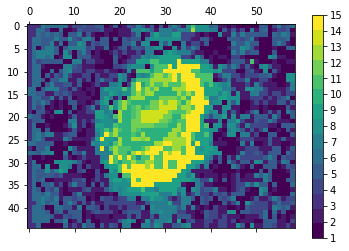

In [10]:
spec.plot_segments()

In [11]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')

spec.filter_clusters(method='remove_islands')

2020-06-15 23:54:42,999  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7}
I0615 23:54:42.999177 140009190655808 segment.py:606] Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

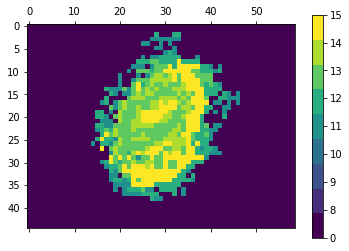

In [12]:
spec.plot_segments()

A manual curation of the segmentation is still possible!

In [13]:
spec.segmented[0:6,] = 0

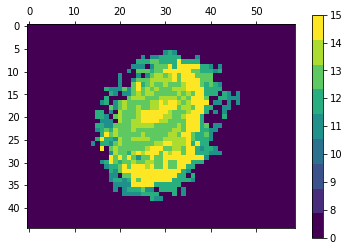

In [14]:
spec.plot_segments()

Consensus Analysis

In [15]:
spec.consensus_spectra()

2020-06-15 23:54:51,971  SpectraRegion  INFO: Calculating consensus spectra
I0615 23:54:51.971645 140009190655808 segment.py:660] Calculating consensus spectra
2020-06-15 23:54:52,052  SpectraRegion  INFO: Calculating consensus spectra done
I0615 23:54:52.052440 140009190655808 segment.py:672] Calculating consensus spectra done


{0: array([0.00178437, 0.00178437, 0.00178437, ..., 0.00077092, 0.00077092,
        0.00077092]),
 8: array([0.00161465, 0.00161465, 0.00161465, ..., 0.00070783, 0.00070783,
        0.00070783]),
 9: array([0.00158939, 0.00158939, 0.00158939, ..., 0.00084206, 0.00084206,
        0.00084206]),
 11: array([0.00160308, 0.00160308, 0.00160308, ..., 0.00072019, 0.00072019,
        0.00072019]),
 15: array([0.00203898, 0.00203898, 0.00203898, ..., 0.00085758, 0.00085758,
        0.00085758]),
 13: array([0.0015091 , 0.0015091 , 0.0015091 , ..., 0.00068435, 0.00068435,
        0.00068435]),
 10: array([0.00261264, 0.00261264, 0.00261264, ..., 0.00074401, 0.00074401,
        0.00074401]),
 12: array([0.00207607, 0.00207607, 0.00207607, ..., 0.00059392, 0.00059392,
        0.00059392]),
 14: array([0.00242908, 0.00242908, 0.00242908, ..., 0.00064484, 0.00064484,
        0.00064484])}

In [16]:
spec.consensus_similarity()

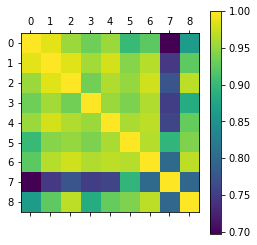

In [17]:
spec.plot_consensus_similarity()

In [ ]:
spec.plot_consensus_similarity(mode="spectra")

In [ ]:
#spec.plot_inter_consensus_similarity()

# Differential Analysis

2020-06-15 23:55:01,700  SpectraRegion  INFO: Processing Mass 12504 with best existing mass 12503.637158007228
I0615 23:55:01.700205 140009190655808 segment.py:232] Processing Mass 12504 with best existing mass 12503.637158007228


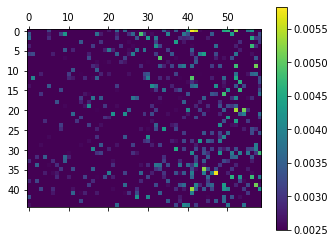

In [18]:
spec.mass_heatmap(12504, min_cut_off=0.0025)

In [ ]:
dfobj = spec.mass_dabest(12504)

In [ ]:
#dfobj = spec.mass_dabest(12504, background=9)

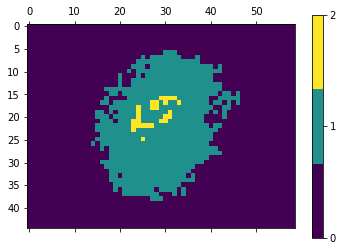

In [20]:
spec.plot_segments(highlight=12)

In [19]:
spec.clear_de_results()

In [21]:
pw = ProteinWeights("protein_weights.tsv")

In [22]:
mgenes = spec.find_all_markers(pw, includeBackground=False, replaceExisting=False, outdirectory="./")

2020-06-15 23:55:37,556  SpectraRegion  INFO: DE data for case: [8]
I0615 23:55:37.556706 140009190655808 segment.py:1229] DE data for case: [8]
2020-06-15 23:55:37,558  SpectraRegion  INFO: DE data for control: [9, 11, 15, 13, 10, 12, 14]
I0615 23:55:37.558256 140009190655808 segment.py:1230] DE data for control: [9, 11, 15, 13, 10, 12, 14]
2020-06-15 23:55:37,561  SpectraRegion  INFO: DE result key: ((8,), (9, 10, 11, 12, 13, 14, 15))
I0615 23:55:37.561334 140009190655808 segment.py:1234] DE result key: ((8,), (9, 10, 11, 12, 13, 14, 15))
2020-06-15 23:55:37,588  SpectraRegion  INFO: Processing cluster: 8
I0615 23:55:37.588839 140009190655808 segment.py:1252] Processing cluster: 8
2020-06-15 23:55:37,660  SpectraRegion  INFO: Processing cluster: 9
I0615 23:55:37.660404 140009190655808 segment.py:1265] Processing cluster: 9


Running [8] against [9, 11, 15, 13, 10, 12, 14]


2020-06-15 23:55:37,796  SpectraRegion  INFO: Processing cluster: 11
I0615 23:55:37.796126 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-15 23:55:37,898  SpectraRegion  INFO: Processing cluster: 15
I0615 23:55:37.898557 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-15 23:55:38,027  SpectraRegion  INFO: Processing cluster: 13
I0615 23:55:38.027570 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-15 23:55:38,172  SpectraRegion  INFO: Processing cluster: 10
I0615 23:55:38.172232 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-15 23:55:38,341  SpectraRegion  INFO: Processing cluster: 12
I0615 23:55:38.341116 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-15 23:55:38,362  SpectraRegion  INFO: Processing cluster: 14
I0615 23:55:38.362171 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-15 23:55:38,384  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0615 23:55:38.384834 14000919065

Max condition count (1, 566)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.8.9_10_11_12_13_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-15 23:59:59,883  SpectraRegion  INFO: Performing DE-test: ttest
I0615 23:59:59.883804 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.8.9_10_11_12_13_14_15.tsv


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2020-06-16 00:00:00,493  SpectraRegion  INFO: DE-test finished. Results available: ((8,), (9, 10, 11, 12, 13, 14, 15))
I0616 00:00:00.493861 140009190655808 segment.py:1363] DE-test finished. Results available: ((8,), (9, 10, 11, 12, 13, 14, 15))
2020-06-16 00:00:00,570  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 16) results
I0616 00:00:00.570583 140009190655808 segment.py:966] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 16) results
2020-06-16 00:00:00,577  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
I0616 00:00:00.577893 140009190655808 segment.py:994] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:00:00

Running [9] against [8, 11, 15, 13, 10, 12, 14]


2020-06-16 00:00:05,051  SpectraRegion  INFO: Processing cluster: 15
I0616 00:00:05.051371 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:00:05,179  SpectraRegion  INFO: Processing cluster: 13
I0616 00:00:05.179284 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:00:05,292  SpectraRegion  INFO: Processing cluster: 10
I0616 00:00:05.292015 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:00:05,456  SpectraRegion  INFO: Processing cluster: 12
I0616 00:00:05.456194 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:00:05,483  SpectraRegion  INFO: Processing cluster: 14
I0616 00:00:05.483033 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:00:05,499  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:00:05.499127 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:00:05,503  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3

Max condition count (1, 540)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.9.8_10_11_12_13_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:05:12,507  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:05:12.507476 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.9.8_10_11_12_13_14_15.tsv


2020-06-16 00:05:13,049  SpectraRegion  INFO: DE-test finished. Results available: ((9,), (8, 10, 11, 12, 13, 14, 15))
I0616 00:05:13.049526 140009190655808 segment.py:1363] DE-test finished. Results available: ((9,), (8, 10, 11, 12, 13, 14, 15))
2020-06-16 00:05:13,113  SpectraRegion  INFO: DE result for case ((9,), (8, 10, 11, 12, 13, 14, 15)) with (17900, 16) results
I0616 00:05:13.113368 140009190655808 segment.py:966] DE result for case ((9,), (8, 10, 11, 12, 13, 14, 15)) with (17900, 16) results
2020-06-16 00:05:13,117  SpectraRegion  INFO: DE result for case ((9,), (8, 10, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
I0616 00:05:13.117883 140009190655808 segment.py:994] DE result for case ((9,), (8, 10, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:05:13,242  SpectraRegion  INFO: Created matrices with shape (120, 17900) and (540, 17900) (target, bg)
I0616 00:05:13.242919 140009190655808 segment.py:1000] Created matrices with shape (120, 17900) and (5

Running [11] against [8, 9, 15, 13, 10, 12, 14]


2020-06-16 00:05:16,660  SpectraRegion  INFO: Processing cluster: 15
I0616 00:05:16.660757 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:05:16,778  SpectraRegion  INFO: Processing cluster: 13
I0616 00:05:16.778590 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:05:16,883  SpectraRegion  INFO: Processing cluster: 10
I0616 00:05:16.883220 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:05:17,046  SpectraRegion  INFO: Processing cluster: 12
I0616 00:05:17.046829 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:05:17,063  SpectraRegion  INFO: Processing cluster: 14
I0616 00:05:17.063013 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:05:17,077  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:05:17.077227 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:05:17,081  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3

Max condition count (1, 541)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.11.8_9_10_12_13_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:10:12,940  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:10:12.940331 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.11.8_9_10_12_13_14_15.tsv


2020-06-16 00:10:13,526  SpectraRegion  INFO: DE-test finished. Results available: ((11,), (8, 9, 10, 12, 13, 14, 15))
I0616 00:10:13.526744 140009190655808 segment.py:1363] DE-test finished. Results available: ((11,), (8, 9, 10, 12, 13, 14, 15))
2020-06-16 00:10:13,587  SpectraRegion  INFO: DE result for case ((11,), (8, 9, 10, 12, 13, 14, 15)) with (17900, 16) results
I0616 00:10:13.587950 140009190655808 segment.py:966] DE result for case ((11,), (8, 9, 10, 12, 13, 14, 15)) with (17900, 16) results
2020-06-16 00:10:13,592  SpectraRegion  INFO: DE result for case ((11,), (8, 9, 10, 12, 13, 14, 15)) with (0, 16) results (filtered)
I0616 00:10:13.592657 140009190655808 segment.py:994] DE result for case ((11,), (8, 9, 10, 12, 13, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:10:13,715  SpectraRegion  INFO: Created matrices with shape (119, 17900) and (541, 17900) (target, bg)
I0616 00:10:13.715845 140009190655808 segment.py:1000] Created matrices with shape (119, 17900) and (5

Running [15] against [8, 9, 11, 13, 10, 12, 14]


2020-06-16 00:10:24,831  SpectraRegion  INFO: Processing cluster: 11
I0616 00:10:24.831517 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 00:10:24,936  SpectraRegion  INFO: Processing cluster: 13
I0616 00:10:24.936175 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:10:25,041  SpectraRegion  INFO: Processing cluster: 10
I0616 00:10:25.041567 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:10:25,199  SpectraRegion  INFO: Processing cluster: 12
I0616 00:10:25.199462 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:10:25,215  SpectraRegion  INFO: Processing cluster: 14
I0616 00:10:25.215768 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:10:25,230  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:10:25.230155 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:10:25,234  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3

Max condition count (1, 517)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.15.8_9_10_11_12_13_14.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:14:50,249  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:14:50.249128 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.15.8_9_10_11_12_13_14.tsv


2020-06-16 00:14:50,796  SpectraRegion  INFO: DE-test finished. Results available: ((15,), (8, 9, 10, 11, 12, 13, 14))
I0616 00:14:50.796483 140009190655808 segment.py:1363] DE-test finished. Results available: ((15,), (8, 9, 10, 11, 12, 13, 14))
2020-06-16 00:14:50,856  SpectraRegion  INFO: DE result for case ((15,), (8, 9, 10, 11, 12, 13, 14)) with (17900, 16) results
I0616 00:14:50.856425 140009190655808 segment.py:966] DE result for case ((15,), (8, 9, 10, 11, 12, 13, 14)) with (17900, 16) results
2020-06-16 00:14:50,860  SpectraRegion  INFO: DE result for case ((15,), (8, 9, 10, 11, 12, 13, 14)) with (0, 16) results (filtered)
I0616 00:14:50.860994 140009190655808 segment.py:994] DE result for case ((15,), (8, 9, 10, 11, 12, 13, 14)) with (0, 16) results (filtered)
2020-06-16 00:14:50,985  SpectraRegion  INFO: Created matrices with shape (143, 17900) and (517, 17900) (target, bg)
I0616 00:14:50.985045 140009190655808 segment.py:1000] Created matrices with shape (143, 17900) and (5

Running [13] against [8, 9, 11, 15, 10, 12, 14]


2020-06-16 00:14:57,163  SpectraRegion  INFO: Processing cluster: 11
I0616 00:14:57.163161 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 00:14:57,298  SpectraRegion  INFO: Processing cluster: 15
I0616 00:14:57.298378 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:14:57,433  SpectraRegion  INFO: Processing cluster: 10
I0616 00:14:57.433934 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:14:57,592  SpectraRegion  INFO: Processing cluster: 12
I0616 00:14:57.592764 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:14:57,607  SpectraRegion  INFO: Processing cluster: 14
I0616 00:14:57.607928 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:14:57,621  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:14:57.621073 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:14:57,626  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3

Max condition count (1, 590)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.13.8_9_10_11_12_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:20:06,662  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:20:06.662011 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.13.8_9_10_11_12_14_15.tsv


2020-06-16 00:20:07,168  SpectraRegion  INFO: DE-test finished. Results available: ((13,), (8, 9, 10, 11, 12, 14, 15))
I0616 00:20:07.168072 140009190655808 segment.py:1363] DE-test finished. Results available: ((13,), (8, 9, 10, 11, 12, 14, 15))
2020-06-16 00:20:07,231  SpectraRegion  INFO: DE result for case ((13,), (8, 9, 10, 11, 12, 14, 15)) with (17900, 16) results
I0616 00:20:07.231288 140009190655808 segment.py:966] DE result for case ((13,), (8, 9, 10, 11, 12, 14, 15)) with (17900, 16) results
2020-06-16 00:20:07,237  SpectraRegion  INFO: DE result for case ((13,), (8, 9, 10, 11, 12, 14, 15)) with (0, 16) results (filtered)
I0616 00:20:07.237286 140009190655808 segment.py:994] DE result for case ((13,), (8, 9, 10, 11, 12, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:20:07,374  SpectraRegion  INFO: Created matrices with shape (70, 17900) and (590, 17900) (target, bg)
I0616 00:20:07.374502 140009190655808 segment.py:1000] Created matrices with shape (70, 17900) and (590

Running [10] against [8, 9, 11, 15, 13, 12, 14]


2020-06-16 00:20:08,655  SpectraRegion  INFO: Processing cluster: 15
I0616 00:20:08.655678 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:20:08,842  SpectraRegion  INFO: Processing cluster: 13
I0616 00:20:08.842244 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:20:09,004  SpectraRegion  INFO: Processing cluster: 12
I0616 00:20:09.004303 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:20:09,019  SpectraRegion  INFO: Processing cluster: 14
I0616 00:20:09.019531 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:20:09,032  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:20:09.032885 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:20:09,039  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3)
I0616 00:20:09.039965 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (660, 3)
2020-06-16 00:20:10,972  SpectraRegion  INFO: St

Max condition count (1, 595)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.10.8_9_11_12_13_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:25:06,536  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:25:06.536663 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.10.8_9_11_12_13_14_15.tsv


2020-06-16 00:25:07,058  SpectraRegion  INFO: DE-test finished. Results available: ((10,), (8, 9, 11, 12, 13, 14, 15))
I0616 00:25:07.058675 140009190655808 segment.py:1363] DE-test finished. Results available: ((10,), (8, 9, 11, 12, 13, 14, 15))
2020-06-16 00:25:07,123  SpectraRegion  INFO: DE result for case ((10,), (8, 9, 11, 12, 13, 14, 15)) with (17900, 16) results
I0616 00:25:07.123058 140009190655808 segment.py:966] DE result for case ((10,), (8, 9, 11, 12, 13, 14, 15)) with (17900, 16) results
2020-06-16 00:25:07,127  SpectraRegion  INFO: DE result for case ((10,), (8, 9, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
I0616 00:25:07.127846 140009190655808 segment.py:994] DE result for case ((10,), (8, 9, 11, 12, 13, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:25:07,269  SpectraRegion  INFO: Created matrices with shape (65, 17900) and (595, 17900) (target, bg)
I0616 00:25:07.269190 140009190655808 segment.py:1000] Created matrices with shape (65, 17900) and (595

Running [12] against [8, 9, 11, 15, 13, 10, 14]


2020-06-16 00:25:13,886  SpectraRegion  INFO: Processing cluster: 15
I0616 00:25:13.886920 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:25:14,112  SpectraRegion  INFO: Processing cluster: 13
I0616 00:25:14.112006 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:25:14,151  SpectraRegion  INFO: Processing cluster: 10
I0616 00:25:14.151638 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:25:14,317  SpectraRegion  INFO: Processing cluster: 14
I0616 00:25:14.317133 140009190655808 segment.py:1265] Processing cluster: 14
2020-06-16 00:25:14,331  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:25:14.331277 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:25:14,335  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3)
I0616 00:25:14.335742 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (660, 3)
2020-06-16 00:25:16,431  SpectraRegion  INFO: St

Max condition count (1, 633)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.12.8_9_10_11_13_14_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:30:10,584  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:30:10.584008 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.12.8_9_10_11_13_14_15.tsv


2020-06-16 00:30:11,165  SpectraRegion  INFO: DE-test finished. Results available: ((12,), (8, 9, 10, 11, 13, 14, 15))
I0616 00:30:11.165053 140009190655808 segment.py:1363] DE-test finished. Results available: ((12,), (8, 9, 10, 11, 13, 14, 15))
2020-06-16 00:30:11,233  SpectraRegion  INFO: DE result for case ((12,), (8, 9, 10, 11, 13, 14, 15)) with (17900, 16) results
I0616 00:30:11.233153 140009190655808 segment.py:966] DE result for case ((12,), (8, 9, 10, 11, 13, 14, 15)) with (17900, 16) results
2020-06-16 00:30:11,238  SpectraRegion  INFO: DE result for case ((12,), (8, 9, 10, 11, 13, 14, 15)) with (0, 16) results (filtered)
I0616 00:30:11.238391 140009190655808 segment.py:994] DE result for case ((12,), (8, 9, 10, 11, 13, 14, 15)) with (0, 16) results (filtered)
2020-06-16 00:30:11,385  SpectraRegion  INFO: Created matrices with shape (27, 17900) and (633, 17900) (target, bg)
I0616 00:30:11.385427 140009190655808 segment.py:1000] Created matrices with shape (27, 17900) and (633

Running [14] against [8, 9, 11, 15, 13, 10, 12]


2020-06-16 00:30:16,716  SpectraRegion  INFO: Processing cluster: 15
I0616 00:30:16.716828 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 00:30:16,838  SpectraRegion  INFO: Processing cluster: 13
I0616 00:30:16.838302 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 00:30:16,946  SpectraRegion  INFO: Processing cluster: 10
I0616 00:30:16.946889 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 00:30:17,109  SpectraRegion  INFO: Processing cluster: 12
I0616 00:30:17.109924 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 00:30:17,127  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 660)
I0616 00:30:17.127288 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 660)
2020-06-16 00:30:17,132  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (660, 3)
I0616 00:30:17.132108 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (660, 3)
2020-06-16 00:30:19,121  SpectraRegion  INFO: St

Max condition count (1, 638)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.14.8_9_10_11_12_13_15.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.re

2020-06-16 00:35:07,955  SpectraRegion  INFO: Performing DE-test: ttest
I0616 00:35:07.955314 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.14.8_9_10_11_12_13_15.tsv


2020-06-16 00:35:08,535  SpectraRegion  INFO: DE-test finished. Results available: ((14,), (8, 9, 10, 11, 12, 13, 15))
I0616 00:35:08.535974 140009190655808 segment.py:1363] DE-test finished. Results available: ((14,), (8, 9, 10, 11, 12, 13, 15))
2020-06-16 00:35:08,597  SpectraRegion  INFO: DE result for case ((14,), (8, 9, 10, 11, 12, 13, 15)) with (17900, 16) results
I0616 00:35:08.597748 140009190655808 segment.py:966] DE result for case ((14,), (8, 9, 10, 11, 12, 13, 15)) with (17900, 16) results
2020-06-16 00:35:08,602  SpectraRegion  INFO: DE result for case ((14,), (8, 9, 10, 11, 12, 13, 15)) with (0, 16) results (filtered)
I0616 00:35:08.602538 140009190655808 segment.py:994] DE result for case ((14,), (8, 9, 10, 11, 12, 13, 15)) with (0, 16) results (filtered)
2020-06-16 00:35:08,744  SpectraRegion  INFO: Created matrices with shape (22, 17900) and (638, 17900) (target, bg)
I0616 00:35:08.744876 140009190655808 segment.py:1000] Created matrices with shape (22, 17900) and (638

In [23]:
spec.list_de_results()

[('empire', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('empire', ((9,), (8, 10, 11, 12, 13, 14, 15))),
 ('empire', ((11,), (8, 9, 10, 12, 13, 14, 15))),
 ('empire', ((15,), (8, 9, 10, 11, 12, 13, 14))),
 ('empire', ((13,), (8, 9, 10, 11, 12, 14, 15))),
 ('empire', ((10,), (8, 9, 11, 12, 13, 14, 15))),
 ('empire', ((12,), (8, 9, 10, 11, 13, 14, 15))),
 ('empire', ((14,), (8, 9, 10, 11, 12, 13, 15))),
 ('ttest', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((9,), (8, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((11,), (8, 9, 10, 12, 13, 14, 15))),
 ('ttest', ((15,), (8, 9, 10, 11, 12, 13, 14))),
 ('ttest', ((13,), (8, 9, 10, 11, 12, 14, 15))),
 ('ttest', ((10,), (8, 9, 11, 12, 13, 14, 15))),
 ('ttest', ((12,), (8, 9, 10, 11, 13, 14, 15))),
 ('ttest', ((14,), (8, 9, 10, 11, 12, 13, 15)))]

In [24]:
markerGenes = mgenes["ttest"]

In [25]:
markerGenes.to_csv("marker_genes.tsv", sep="\t", index=False)

In [30]:
markerGenesEmpire = mgenes["empire"]
markerGenesEmpire.to_csv("marker_genes_empire.tsv", sep="\t", index=False)

In [31]:
mgenes_bg = spec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest"])

2020-06-16 10:08:24,610  SpectraRegion  INFO: DE data for case: [0]
I0616 10:08:24.610713 140009190655808 segment.py:1229] DE data for case: [0]
2020-06-16 10:08:24,612  SpectraRegion  INFO: DE data for control: [8, 9, 11, 15, 13, 10, 12, 14]
I0616 10:08:24.612854 140009190655808 segment.py:1230] DE data for control: [8, 9, 11, 15, 13, 10, 12, 14]
2020-06-16 10:08:24,614  SpectraRegion  INFO: DE result key: ((0,), (8, 9, 10, 11, 12, 13, 14, 15))
I0616 10:08:24.614548 140009190655808 segment.py:1234] DE result key: ((0,), (8, 9, 10, 11, 12, 13, 14, 15))
2020-06-16 10:08:24,647  SpectraRegion  INFO: Processing cluster: 0
I0616 10:08:24.647448 140009190655808 segment.py:1252] Processing cluster: 0


Running [0] against [8, 9, 11, 15, 13, 10, 12, 14]


2020-06-16 10:08:29,643  SpectraRegion  INFO: Processing cluster: 8
I0616 10:08:29.643687 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:08:30,125  SpectraRegion  INFO: Processing cluster: 9
I0616 10:08:30.125756 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:08:31,110  SpectraRegion  INFO: Processing cluster: 11
I0616 10:08:31.110294 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:08:31,690  SpectraRegion  INFO: Processing cluster: 15
I0616 10:08:31.690760 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:08:32,301  SpectraRegion  INFO: Processing cluster: 13
I0616 10:08:32.301574 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:08:32,894  SpectraRegion  INFO: Processing cluster: 10
I0616 10:08:32.894404 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:08:33,497  SpectraRegion  INFO: Processing cluster: 12
I0616 10:08:33.497476 140009190655808 segment.py:1265

Running [8] against [0, 9, 11, 15, 13, 10, 12, 14]


2020-06-16 10:08:50,033  SpectraRegion  INFO: Processing cluster: 9
I0616 10:08:50.033612 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:08:51,035  SpectraRegion  INFO: Processing cluster: 11
I0616 10:08:51.035621 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:08:51,619  SpectraRegion  INFO: Processing cluster: 15
I0616 10:08:51.619575 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:08:52,241  SpectraRegion  INFO: Processing cluster: 13
I0616 10:08:52.241501 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:08:52,845  SpectraRegion  INFO: Processing cluster: 10
I0616 10:08:52.845167 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:08:53,454  SpectraRegion  INFO: Processing cluster: 12
I0616 10:08:53.454303 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:08:53,487  SpectraRegion  INFO: Processing cluster: 14
I0616 10:08:53.487832 140009190655808 segment.py:12

Running [9] against [0, 8, 11, 15, 13, 10, 12, 14]


2020-06-16 10:09:03,430  SpectraRegion  INFO: Processing cluster: 8
I0616 10:09:03.430050 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:09:03,976  SpectraRegion  INFO: Processing cluster: 11
I0616 10:09:03.976510 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:09:04,599  SpectraRegion  INFO: Processing cluster: 15
I0616 10:09:04.599050 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:09:05,279  SpectraRegion  INFO: Processing cluster: 13
I0616 10:09:05.279444 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:09:05,912  SpectraRegion  INFO: Processing cluster: 10
I0616 10:09:05.912777 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:09:06,593  SpectraRegion  INFO: Processing cluster: 12
I0616 10:09:06.593979 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:09:06,626  SpectraRegion  INFO: Processing cluster: 14
I0616 10:09:06.626789 140009190655808 segment.py:12

Running [11] against [0, 8, 9, 15, 13, 10, 12, 14]


2020-06-16 10:09:18,048  SpectraRegion  INFO: Processing cluster: 8
I0616 10:09:18.048694 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:09:18,605  SpectraRegion  INFO: Processing cluster: 9
I0616 10:09:18.605276 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:09:19,172  SpectraRegion  INFO: Processing cluster: 15
I0616 10:09:19.172744 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:09:19,770  SpectraRegion  INFO: Processing cluster: 13
I0616 10:09:19.770067 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:09:20,339  SpectraRegion  INFO: Processing cluster: 10
I0616 10:09:20.339926 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:09:20,933  SpectraRegion  INFO: Processing cluster: 12
I0616 10:09:20.933850 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:09:20,961  SpectraRegion  INFO: Processing cluster: 14
I0616 10:09:20.961413 140009190655808 segment.py:1265

Running [15] against [0, 8, 9, 11, 13, 10, 12, 14]


2020-06-16 10:09:42,754  SpectraRegion  INFO: Processing cluster: 8
I0616 10:09:42.754173 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:09:43,304  SpectraRegion  INFO: Processing cluster: 9
I0616 10:09:43.304804 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:09:43,869  SpectraRegion  INFO: Processing cluster: 11
I0616 10:09:43.869746 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:09:44,453  SpectraRegion  INFO: Processing cluster: 13
I0616 10:09:44.453898 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:09:45,024  SpectraRegion  INFO: Processing cluster: 10
I0616 10:09:45.024204 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:09:45,632  SpectraRegion  INFO: Processing cluster: 12
I0616 10:09:45.632972 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:09:45,659  SpectraRegion  INFO: Processing cluster: 14
I0616 10:09:45.659852 140009190655808 segment.py:1265

Running [13] against [0, 8, 9, 11, 15, 10, 12, 14]


2020-06-16 10:10:10,249  SpectraRegion  INFO: Processing cluster: 8
I0616 10:10:10.249067 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:10:10,750  SpectraRegion  INFO: Processing cluster: 9
I0616 10:10:10.750910 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:10:11,290  SpectraRegion  INFO: Processing cluster: 11
I0616 10:10:11.290780 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:10:11,860  SpectraRegion  INFO: Processing cluster: 15
I0616 10:10:11.860034 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:10:12,990  SpectraRegion  INFO: Processing cluster: 10
I0616 10:10:12.990932 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:10:13,591  SpectraRegion  INFO: Processing cluster: 12
I0616 10:10:13.591074 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:10:13,615  SpectraRegion  INFO: Processing cluster: 14
I0616 10:10:13.615975 140009190655808 segment.py:1265

Running [10] against [0, 8, 9, 11, 15, 13, 12, 14]


2020-06-16 10:10:31,430  SpectraRegion  INFO: Processing cluster: 8
I0616 10:10:31.430371 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:10:31,932  SpectraRegion  INFO: Processing cluster: 9
I0616 10:10:31.932838 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:10:32,470  SpectraRegion  INFO: Processing cluster: 11
I0616 10:10:32.470901 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:10:33,024  SpectraRegion  INFO: Processing cluster: 15
I0616 10:10:33.024459 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:10:34,132  SpectraRegion  INFO: Processing cluster: 13
I0616 10:10:34.132410 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:10:34,716  SpectraRegion  INFO: Processing cluster: 12
I0616 10:10:34.716607 140009190655808 segment.py:1265] Processing cluster: 12
2020-06-16 10:10:34,741  SpectraRegion  INFO: Processing cluster: 14
I0616 10:10:34.741470 140009190655808 segment.py:1265

Running [12] against [0, 8, 9, 11, 15, 13, 10, 14]


2020-06-16 10:10:51,344  SpectraRegion  INFO: Processing cluster: 8
I0616 10:10:51.344087 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:10:51,843  SpectraRegion  INFO: Processing cluster: 9
I0616 10:10:51.843713 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:10:52,379  SpectraRegion  INFO: Processing cluster: 11
I0616 10:10:52.379660 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:10:52,949  SpectraRegion  INFO: Processing cluster: 15
I0616 10:10:52.949800 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:10:53,548  SpectraRegion  INFO: Processing cluster: 13
I0616 10:10:53.548044 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:10:54,116  SpectraRegion  INFO: Processing cluster: 10
I0616 10:10:54.116464 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:10:54,705  SpectraRegion  INFO: Processing cluster: 14
I0616 10:10:54.705479 140009190655808 segment.py:1265

Running [14] against [0, 8, 9, 11, 15, 13, 10, 12]


2020-06-16 10:11:15,162  SpectraRegion  INFO: Processing cluster: 8
I0616 10:11:15.162851 140009190655808 segment.py:1265] Processing cluster: 8
2020-06-16 10:11:15,666  SpectraRegion  INFO: Processing cluster: 9
I0616 10:11:15.666396 140009190655808 segment.py:1265] Processing cluster: 9
2020-06-16 10:11:16,208  SpectraRegion  INFO: Processing cluster: 11
I0616 10:11:16.208869 140009190655808 segment.py:1265] Processing cluster: 11
2020-06-16 10:11:16,797  SpectraRegion  INFO: Processing cluster: 15
I0616 10:11:16.797561 140009190655808 segment.py:1265] Processing cluster: 15
2020-06-16 10:11:17,384  SpectraRegion  INFO: Processing cluster: 13
I0616 10:11:17.384129 140009190655808 segment.py:1265] Processing cluster: 13
2020-06-16 10:11:17,950  SpectraRegion  INFO: Processing cluster: 10
I0616 10:11:17.950065 140009190655808 segment.py:1265] Processing cluster: 10
2020-06-16 10:11:18,532  SpectraRegion  INFO: Processing cluster: 12
I0616 10:11:18.532749 140009190655808 segment.py:1265

In [33]:
markerGenesBG = mgenes_bg["ttest"]
markerGenesBG.to_csv("marker_genes_bg.tsv", sep="\t", index=False)
markerGenesBGEmpire = mgenes_bg["empire"]
markerGenesBGEmpire.to_csv("marker_genes_bg_empire.tsv", sep="\t", index=False)

In [34]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(markerGenes["gene"]))))

Number of unique, differentially detected proteins (from masses): 329


In [36]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(markerGenesBG["gene"]))))

Number of unique, differentially detected proteins (from masses): 448


In [40]:
resClus8 = spec.find_de_results( (8,) )
resClus8

[('empire', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((8,), (0, 9, 10, 11, 12, 13, 14, 15)))]

In [47]:
deResDFs = spec.get_de_results( resClus8[1][1] )
deRes = spec.deres_to_df(deResDFs["ttest"], resClus8[1][1], pw)


2020-06-16 10:19:27,575  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 7) results
I0616 10:19:27.575583 140009190655808 segment.py:966] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 7) results
2020-06-16 10:19:27,583  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (761, 7) results (filtered)
I0616 10:19:27.583134 140009190655808 segment.py:994] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (761, 7) results (filtered)
2020-06-16 10:19:27,764  SpectraRegion  INFO: Created matrices with shape (94, 17900) and (566, 17900) (target, bg)
I0616 10:19:27.764873 140009190655808 segment.py:1000] Created matrices with shape (94, 17900) and (566, 17900) (target, bg)


In [48]:
deRes.to_csv("region1_cluster8.tsv", sep="\t")

# Cell-type detection

Cell-type detection requires analyseMarkers.py from https://github.com/mjoppich/scrnaseq_celltype_prediction .

In [26]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes.tsv -n 4

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
8	Hepatic stellate cells;Liver	0.005373146470530798	1	46	{'RBP1'}
8	Hepatocytes;Liver	0.0017408953840481714	1	154	{'HAMP'}
8	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
8	Mast cells;Immune system	0.0	1	162	{'PCP4L1'}
9	Hepatic stellate cells;Liver	0.006362411095540666	1	46	{'RBP1'}
9	Hepatocytes;Liver	0.001290034910489871	1	154	{'HAMP'}
9	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
9	Mast cells;Immune system	0.0	1	162	{'PCP4L1'}
10	Basophils;Immune system	0.0	1	82	{'IFITM1'}
10	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
10	Gamma delta T cells;Immune system	0.0	2	66	{'IFITM1', 'H2AFX'}
10	Hepatic stellate cells;Liver	0.0	1	46	{'RBP1'}
11	Adipocytes;Connective tissue	0.0	1	120	{'NNMT'}
11	B cells memory;Immune system	0.

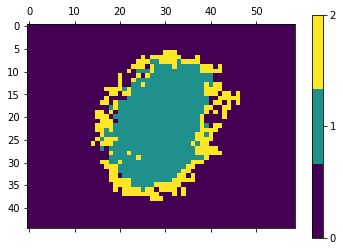

In [27]:
spec.plot_segments(highlight=(8,9))

In [49]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_bg.tsv -n 4

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
0	Hepatic stellate cells;Liver	0.007273730120504114	1	46	{'RBP1'}
0	Hepatocytes;Liver	0.0034795070306199412	2	154	{'HAMP', 'APOA2'}
0	Smooth muscle cells;Smooth muscle	0.0031316825887694796	3	82	{'SNCG', 'PCP4L1', 'RBPMS2'}
0	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
10	Monocytes;Immune system	0.003709001612952966	1	102	{'IFITM3'}
10	Smooth muscle cells;Smooth muscle	0.0029248763947420805	2	82	{'SNCG', 'PCP4L1'}
10	Mast cells;Immune system	2.648429475636906e-05	1	162	{'PCP4L1'}
10	Cardiomyocytes;Heart	0.0	2	106	{'HAMP', 'MYL2'}
11	Adipocytes;Connective tissue	0.0	1	120	{'NNMT'}
11	Basal cells;Epithelium	0.0	1	56	{'NNMT'}
11	Cardiomyocytes;Heart	0.0	2	106	{'HAMP', 'MYL2'}
11	Chondrocytes;Connective tissue	0.0	

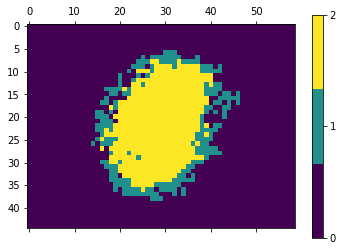

In [50]:
spec.plot_segments(highlight=(10,11,12,13,14,15))

In [ ]:
spec.to_aorta3d("./slided_test/", "slided", 0, protWeights=pw, nodf=True, pathPrefix="../data/test_msi/")

# Preparations for CombinedSpectra

Found region 1 with shape (43, 56, 17900)
I0616 13:22:15.409117 140009190655808 segment.py:1935] Found region 1 with shape (43, 56, 17900)


3454.87441091502 6
3456.383544128344 106
3457.8926773416683 2282
6651.218556735783 1
4749.710707947227 13


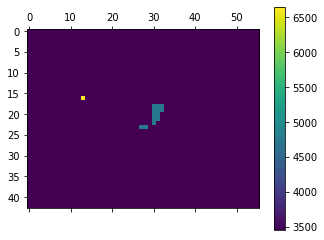

2408 0.064910434 1.0 0.41083783311057726


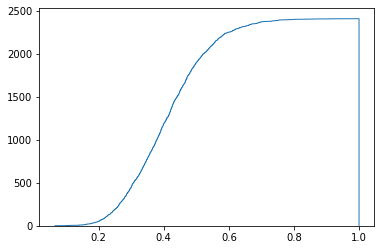

Got spectra (43, 56, 17900)
(43, 56, 17900)


2020-06-16 13:22:18,205  SpectraRegion  INFO: Creating C++ obj
2020-06-16 13:22:18,205  SpectraRegion  INFO: Creating C++ obj
I0616 13:22:18.205235 140009190655808 segment.py:264] Creating C++ obj
2020-06-16 13:22:18,207  SpectraRegion  INFO: dimensions 17900
2020-06-16 13:22:18,207  SpectraRegion  INFO: dimensions 17900
I0616 13:22:18.207868 140009190655808 segment.py:274] dimensions 17900
2020-06-16 13:22:18,213  SpectraRegion  INFO: input dimensions (43, 56, 17900)
2020-06-16 13:22:18,213  SpectraRegion  INFO: input dimensions (43, 56, 17900)
I0616 13:22:18.213472 140009190655808 segment.py:275] input dimensions (43, 56, 17900)
2020-06-16 13:22:18,219  SpectraRegion  INFO: Switching to dot mode
2020-06-16 13:22:18,219  SpectraRegion  INFO: Switching to dot mode
I0616 13:22:18.219383 140009190655808 segment.py:278] Switching to dot mode
2020-06-16 13:22:18,222  SpectraRegion  INFO: Starting calc similarity c++
2020-06-16 13:22:18,222  SpectraRegion  INFO: Starting calc similarity c++

(2408, 2408)


2020-06-16 13:25:33,807  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 13:25:33,807  SpectraRegion  INFO: Calculating dist pixel map done
I0616 13:25:33.807442 140009190655808 segment.py:337] Calculating dist pixel map done
2020-06-16 13:25:33,898  SpectraRegion  INFO: Calculating clusters
2020-06-16 13:25:33,898  SpectraRegion  INFO: Calculating clusters
I0616 13:25:33.898677 140009190655808 segment.py:484] Calculating clusters
2020-06-16 13:25:34,166  SpectraRegion  INFO: Calculating clusters done
2020-06-16 13:25:34,166  SpectraRegion  INFO: Calculating clusters done
I0616 13:25:34.166961 140009190655808 segment.py:499] Calculating clusters done
2020-06-16 13:25:34,187  SpectraRegion  INFO: Calculating clusters saved
2020-06-16 13:25:34,187  SpectraRegion  INFO: Calculating clusters saved
I0616 13:25:34.187759 140009190655808 segment.py:517] Calculating clusters saved


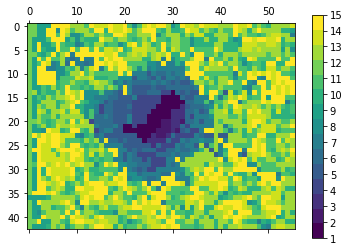

In [51]:
spectra1 = imze.get_region_array(1, makeNullLine=True)
imze.normalize_region_array(spectra1, normalize="vector")
imze.list_highest_peaks(spectra1, counter=True)
print("Got spectra", spectra1.shape)

spec1 = SpectraRegion(spectra1, imze.mzValues)
spec1.calculate_similarity(mode="spectra_log_dist")
spec1.segment(method="WARD", number_of_regions=15)
spec1.plot_segments()

2020-06-16 13:27:22,941  SpectraRegion  INFO: Assigning clusters to background: {7, 8, 9, 10, 11, 12, 13, 14, 15}
2020-06-16 13:27:22,941  SpectraRegion  INFO: Assigning clusters to background: {7, 8, 9, 10, 11, 12, 13, 14, 15}
I0616 13:27:22.941869 140009190655808 segment.py:606] Assigning clusters to background: {7, 8, 9, 10, 11, 12, 13, 14, 15}


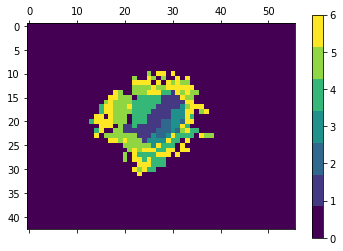

In [52]:
spec1.filter_clusters(method='remove_singleton')
spec1.filter_clusters(method='merge_background')

spec1.filter_clusters(method='remove_islands')
spec1.plot_segments()

2020-06-16 13:27:59,905  SpectraRegion  INFO: Calculating consensus spectra
2020-06-16 13:27:59,905  SpectraRegion  INFO: Calculating consensus spectra
I0616 13:27:59.905105 140009190655808 segment.py:660] Calculating consensus spectra
2020-06-16 13:27:59,976  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-16 13:27:59,976  SpectraRegion  INFO: Calculating consensus spectra done
I0616 13:27:59.976039 140009190655808 segment.py:672] Calculating consensus spectra done


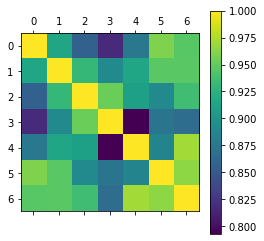

2020-06-16 13:28:00,235  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6]
2020-06-16 13:28:00,235  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6]
I0616 13:28:00.235972 140009190655808 segment.py:790] Found clusterLabels [0, 1, 2, 3, 4, 5, 6]
2020-06-16 13:28:00,239  SpectraRegion  INFO: Processing clusterLabel 0
2020-06-16 13:28:00,239  SpectraRegion  INFO: Processing clusterLabel 0
I0616 13:28:00.239853 140009190655808 segment.py:798] Processing clusterLabel 0
2020-06-16 13:28:41,370  SpectraRegion  INFO: Processing clusterLabel 1
2020-06-16 13:28:41,370  SpectraRegion  INFO: Processing clusterLabel 1
I0616 13:28:41.370414 140009190655808 segment.py:798] Processing clusterLabel 1
2020-06-16 13:28:41,390  SpectraRegion  INFO: Processing clusterLabel 2
2020-06-16 13:28:41,390  SpectraRegion  INFO: Processing clusterLabel 2
I0616 13:28:41.390138 140009190655808 segment.py:798] Processing clusterLabel 2
2020-06-16 13:28:41,396  SpectraRegion  INFO: Processing

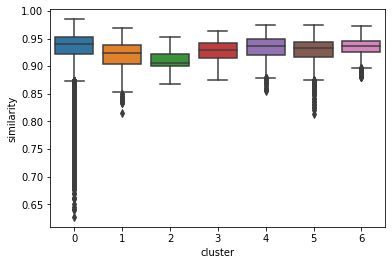

In [53]:
spec1.consensus_spectra()
spec1.consensus_similarity()
spec1.plot_consensus_similarity()
spec1.plot_consensus_similarity(mode="spectra")


In [54]:
mgenes1 = spec1.find_all_markers(pw, includeBackground=False, replaceExisting=False, outdirectory="./")

2020-06-16 13:29:12,215  SpectraRegion  INFO: DE data for case: [5]
2020-06-16 13:29:12,215  SpectraRegion  INFO: DE data for case: [5]
I0616 13:29:12.215579 140009190655808 segment.py:1229] DE data for case: [5]
2020-06-16 13:29:12,218  SpectraRegion  INFO: DE data for control: [6, 4, 1, 3, 2]
2020-06-16 13:29:12,218  SpectraRegion  INFO: DE data for control: [6, 4, 1, 3, 2]
I0616 13:29:12.218883 140009190655808 segment.py:1230] DE data for control: [6, 4, 1, 3, 2]
2020-06-16 13:29:12,223  SpectraRegion  INFO: DE result key: ((5,), (1, 2, 3, 4, 6))
2020-06-16 13:29:12,223  SpectraRegion  INFO: DE result key: ((5,), (1, 2, 3, 4, 6))
I0616 13:29:12.223038 140009190655808 segment.py:1234] DE result key: ((5,), (1, 2, 3, 4, 6))
2020-06-16 13:29:12,253  SpectraRegion  INFO: Processing cluster: 5
2020-06-16 13:29:12,253  SpectraRegion  INFO: Processing cluster: 5
I0616 13:29:12.253008 140009190655808 segment.py:1252] Processing cluster: 5
2020-06-16 13:29:12,303  SpectraRegion  INFO: Proces

Running [5] against [6, 4, 1, 3, 2]


2020-06-16 13:29:12,431  SpectraRegion  INFO: Processing cluster: 3
2020-06-16 13:29:12,431  SpectraRegion  INFO: Processing cluster: 3
I0616 13:29:12.431995 140009190655808 segment.py:1265] Processing cluster: 3
2020-06-16 13:29:12,446  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 13:29:12,446  SpectraRegion  INFO: Processing cluster: 2
I0616 13:29:12.446618 140009190655808 segment.py:1265] Processing cluster: 2
2020-06-16 13:29:12,458  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:29:12,458  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:29:12.458348 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:29:12,466  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:29:12,466  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:29:12.466791 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:29:13,016  SpectraRegio

Max condition count (1, 227)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.5.1_2_3_4_6.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:30:51,149  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:30:51,149  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:30:51.149674 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.5.1_2_3_4_6.tsv


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2020-06-16 13:30:51,406  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6))
2020-06-16 13:30:51,406  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6))
I0616 13:30:51.406026 140009190655808 segment.py:1363] DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6))
2020-06-16 13:30:51,430  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6)) with (17900, 16) results
2020-06-16 13:30:51,430  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6)) with (17900, 16) results
I0616 13:30:51.430043 140009190655808 segment.py:966] DE result for case ((5,), (1, 2, 3, 4, 6)) with (17900, 16) results
2020-06-16 13:30:51,439  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6)) with (0, 16) results (filtered)

Running [6] against [5, 4, 1, 3, 2]


2020-06-16 13:30:59,647  SpectraRegion  INFO: Processing cluster: 2
I0616 13:30:59.647082 140009190655808 segment.py:1265] Processing cluster: 2
2020-06-16 13:30:59,657  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:30:59,657  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:30:59.657107 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:30:59,663  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:30:59,663  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:30:59.663909 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:31:00,137  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
2020-06-16 13:31:00,137  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
I0616 13:31:00.137919 140009190655808 segment.py:1302] Starting EMPIRE; Writing Expression Files
2020-06-16 13:31:08,579  SpectraRegion  INFO:

Max condition count (1, 209)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.6.1_2_3_4_5.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:32:27,412  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:32:27,412  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:32:27.412960 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.6.1_2_3_4_5.tsv


2020-06-16 13:32:27,637  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5))
2020-06-16 13:32:27,637  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5))
I0616 13:32:27.637381 140009190655808 segment.py:1363] DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5))
2020-06-16 13:32:27,662  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5)) with (17900, 16) results
2020-06-16 13:32:27,662  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5)) with (17900, 16) results
I0616 13:32:27.662943 140009190655808 segment.py:966] DE result for case ((6,), (1, 2, 3, 4, 5)) with (17900, 16) results
2020-06-16 13:32:27,669  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5)) with (0, 16) results (filtered)
2020-06-16 13:32:27,669  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5)) with (0, 16) results (filtered)
I0616 13:32:27.669218 140009190655808 segment.py:994] DE result for case ((6,)

Running [4] against [5, 6, 1, 3, 2]


2020-06-16 13:32:28,584  SpectraRegion  INFO: Processing cluster: 3
2020-06-16 13:32:28,584  SpectraRegion  INFO: Processing cluster: 3
I0616 13:32:28.584613 140009190655808 segment.py:1265] Processing cluster: 3
2020-06-16 13:32:28,597  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 13:32:28,597  SpectraRegion  INFO: Processing cluster: 2
I0616 13:32:28.597785 140009190655808 segment.py:1265] Processing cluster: 2
2020-06-16 13:32:28,607  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:32:28,607  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:32:28.607632 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:32:28,614  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:32:28,614  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:32:28.614877 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:32:29,158  SpectraRegio

Max condition count (1, 239)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.4.1_2_3_5_6.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:34:08,154  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:34:08,154  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:34:08.154702 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.4.1_2_3_5_6.tsv


2020-06-16 13:34:08,378  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6))
2020-06-16 13:34:08,378  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6))
I0616 13:34:08.378789 140009190655808 segment.py:1363] DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6))
2020-06-16 13:34:08,400  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6)) with (17900, 16) results
2020-06-16 13:34:08,400  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6)) with (17900, 16) results
I0616 13:34:08.400892 140009190655808 segment.py:966] DE result for case ((4,), (1, 2, 3, 5, 6)) with (17900, 16) results
2020-06-16 13:34:08,406  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6)) with (0, 16) results (filtered)
2020-06-16 13:34:08,406  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6)) with (0, 16) results (filtered)
I0616 13:34:08.406865 140009190655808 segment.py:994] DE result for case ((4,)

Running [1] against [5, 6, 4, 3, 2]


2020-06-16 13:34:16,168  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 13:34:16,168  SpectraRegion  INFO: Processing cluster: 2
I0616 13:34:16.168396 140009190655808 segment.py:1265] Processing cluster: 2
2020-06-16 13:34:16,178  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:34:16,178  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:34:16.178117 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:34:16,183  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:34:16,183  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:34:16.183818 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:34:16,670  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
2020-06-16 13:34:16,670  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
I0616 13:34:16.670597 140009190655808 segment.py:1302] Starting EMPIRE; Wr

Max condition count (1, 255)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.1.2_3_4_5_6.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:36:03,906  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:36:03,906  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:36:03.906200 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.1.2_3_4_5_6.tsv


2020-06-16 13:36:04,109  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6))
2020-06-16 13:36:04,109  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6))
I0616 13:36:04.109986 140009190655808 segment.py:1363] DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6))
2020-06-16 13:36:04,132  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:36:04,132  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6)) with (17900, 16) results
I0616 13:36:04.132883 140009190655808 segment.py:966] DE result for case ((1,), (2, 3, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:36:04,139  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6)) with (0, 16) results (filtered)
2020-06-16 13:36:04,139  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6)) with (0, 16) results (filtered)
I0616 13:36:04.139546 140009190655808 segment.py:994] DE result for case ((1,)

Running [3] against [5, 6, 4, 1, 2]


2020-06-16 13:36:06,852  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:36:06,852  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:36:06.852001 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:36:06,858  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:36:06,858  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:36:06.858245 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:36:07,398  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
2020-06-16 13:36:07,398  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
I0616 13:36:07.398591 140009190655808 segment.py:1302] Starting EMPIRE; Writing Expression Files
2020-06-16 13:36:15,941  SpectraRegion  INFO: Starting EMPIRE; Running nlEmpiRe
2020-06-16 13:36:15,941  SpectraRegion  INFO: Starting EMPIRE; Running nlEmpiRe
I0616 13:36:15.941500 14000919

Max condition count (1, 281)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.3.1_2_4_5_6.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:38:09,132  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:38:09,132  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:38:09.132237 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.3.1_2_4_5_6.tsv


2020-06-16 13:38:09,376  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6))
2020-06-16 13:38:09,376  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6))
I0616 13:38:09.376635 140009190655808 segment.py:1363] DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6))
2020-06-16 13:38:09,401  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:38:09,401  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6)) with (17900, 16) results
I0616 13:38:09.401878 140009190655808 segment.py:966] DE result for case ((3,), (1, 2, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:38:09,407  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6)) with (0, 16) results (filtered)
2020-06-16 13:38:09,407  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6)) with (0, 16) results (filtered)
I0616 13:38:09.407108 140009190655808 segment.py:994] DE result for case ((3,)

Running [2] against [5, 6, 4, 1, 3]


2020-06-16 13:38:17,125  SpectraRegion  INFO: Processing cluster: 3
2020-06-16 13:38:17,125  SpectraRegion  INFO: Processing cluster: 3
I0616 13:38:17.125376 140009190655808 segment.py:1265] Processing cluster: 3
2020-06-16 13:38:17,138  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:38:17,138  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 300)
I0616 13:38:17.138824 140009190655808 segment.py:1278] DE DataFrame ready. Shape (17900, 300)
2020-06-16 13:38:17,144  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:38:17,144  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (300, 3)
I0616 13:38:17.144839 140009190655808 segment.py:1286] DE Sample DataFrame ready. Shape (300, 3)
2020-06-16 13:38:17,603  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
2020-06-16 13:38:17,603  SpectraRegion  INFO: Starting EMPIRE; Writing Expression Files
I0616 13:38:17.603354 140009190655808 segment.py:1302] Starting EMPIRE; Wr

Max condition count (1, 289)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//nldiffreg.2.1_3_4_5_6.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, cond2

2020-06-16 13:40:19,467  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 13:40:19,467  SpectraRegion  INFO: Performing DE-test: ttest
I0616 13:40:19.467785 140009190655808 segment.py:1338] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//nldiffreg.2.1_3_4_5_6.tsv


2020-06-16 13:40:19,725  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6))
2020-06-16 13:40:19,725  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6))
I0616 13:40:19.725131 140009190655808 segment.py:1363] DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6))
2020-06-16 13:40:19,758  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:40:19,758  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6)) with (17900, 16) results
I0616 13:40:19.758427 140009190655808 segment.py:966] DE result for case ((2,), (1, 3, 4, 5, 6)) with (17900, 16) results
2020-06-16 13:40:19,769  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6)) with (0, 16) results (filtered)
2020-06-16 13:40:19,769  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6)) with (0, 16) results (filtered)
I0616 13:40:19.769100 140009190655808 segment.py:994] DE result for case ((2,)

In [56]:
spec1.list_de_results()
markerGenes1 = mgenes1["ttest"]
markerGenes1.to_csv("marker_genes_region_1.tsv", sep="\t", index=False)


In [57]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_1.tsv -n 4

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 6 clusters.
Starting analysis
1	Hepatic stellate cells;Liver	0.0	1	46	{'RBP1'}
2	Adipocytes;Connective tissue	0.0	1	120	{'PXMP2'}
2	Basal cells;Epithelium	0.0	1	56	{'DNPH1'}
2	Basophils;Immune system	0.0	1	82	{'IFITM1'}
2	Cardiomyocytes;Heart	0.0	6	106	{'HAMP', 'MYL2', 'MYL3', 'TNNC1', 'HMGB2', 'TNNI3'}
3	Basophils;Immune system	0.0	2	82	{'IGFBP7', 'IFITM1'}
3	Endothelial cells;Vasculature	0.0	3	195	{'IGFBP7', 'CD9', 'S100A10'}
3	Gamma delta T cells;Immune system	0.0	1	66	{'IFITM1'}
3	Hepatic stellate cells;Liver	0.0	2	46	{'MYL9', 'IGFBP7'}
4	Hepatocytes;Liver	0.005333990321576602	1	154	{'APOA2'}
4	Mesothelial cells;Epithelium	0.005083194424851952	1	58	{'GSTA3'}
4	Pericytes;Vasculature	0.00374993854544025	1	64	{'IFITM1'}
4	Basophils;Imm

# Creating a CombinedSpectra

In [96]:
spec.name = "region0"
spec1.name = "region1"
spec4.name = "region4"

In [97]:
combSpec = CombinedSpectra({0: spec, 1: spec1, 4: spec4})

In [109]:
combSpec.consensus_similarity()

2020-06-17 10:34:06,023  SpectraRegion  INFO: Calculating consensus spectra
2020-06-17 10:34:06,023  SpectraRegion  INFO: Calculating consensus spectra
2020-06-17 10:34:06,023  SpectraRegion  INFO: Calculating consensus spectra
2020-06-17 10:34:06,023  SpectraRegion  INFO: Calculating consensus spectra
2020-06-17 10:34:06,023  SpectraRegion  INFO: Calculating consensus spectra
I0617 10:34:06.023848 140009190655808 segment.py:717] Calculating consensus spectra
2020-06-17 10:34:06,120  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-17 10:34:06,120  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-17 10:34:06,120  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-17 10:34:06,120  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-17 10:34:06,120  SpectraRegion  INFO: Calculating consensus spectra done
I0617 10:34:06.120134 140009190655808 segment.py:729] Calculating consensus spectra done
2020-06-17 10:34:06,124  SpectraRegion  IN

In [110]:
combSpec.consensus_similarity_matrix

,"(region0, 0)","(region0, 8)","(region0, 9)","(region0, 10)","(region0, 11)","(region0, 12)","(region0, 13)","(region0, 14)","(region0, 15)","(region1, 0)",...,"(region4, 6)","(region4, 7)","(region4, 8)","(region4, 9)","(region4, 10)","(region4, 11)","(region4, 12)","(region4, 13)","(region4, 14)","(region4, 15)"
"(region0, 0)",1.000000,0.987037,0.953862,0.932723,0.954484,0.902774,0.923359,0.696562,0.864633,0.978511,...,0.973843,0.987258,0.994588,0.925343,0.937144,0.947890,0.990908,0.987669,0.968427,0.967413
"(region0, 8)",0.987037,1.000000,0.985080,0.957895,0.980283,0.944952,0.966460,0.746363,0.925007,0.986391,...,0.948301,0.971662,0.989272,0.962480,0.975058,0.970596,0.982405,0.986949,0.975760,0.990953
"(region0, 9)",0.953862,0.985080,1.000000,0.935674,0.963406,0.951537,0.978014,0.776154,0.970010,0.966776,...,0.917726,0.922255,0.958821,0.961225,0.970730,0.944225,0.952886,0.973360,0.979395,0.992233
"(region0, 10)",0.932723,0.957895,0.935674,1.000000,0.953952,0.939820,0.964300,0.752588,0.884299,0.935086,...,0.881739,0.926149,0.936793,0.979087,0.965133,0.990614,0.941168,0.931158,0.915469,0.954786
"(region0, 11)",0.954484,0.980283,0.963406,0.953952,1.000000,0.961462,0.969725,0.760376,0.928736,0.966018,...,0.908169,0.956740,0.964534,0.948926,0.992436,0.973039,0.940741,0.943603,0.923843,0.963542
"(region0, 12)",0.902774,0.944952,0.951537,0.939820,0.961462,1.000000,0.966337,0.896586,0.941156,0.924559,...,0.861006,0.890417,0.914776,0.934222,0.974142,0.943373,0.898306,0.912412,0.908966,0.944365
"(region0, 13)",0.923359,0.966460,0.978014,0.964300,0.969725,0.966337,1.000000,0.801668,0.969383,0.939614,...,0.880646,0.899306,0.930739,0.974156,0.984951,0.961823,0.922513,0.937189,0.939546,0.974044
"(region0, 14)",0.696562,0.746363,0.776154,0.752588,0.760376,0.896586,0.801668,1.000000,0.796207,0.724432,...,0.672959,0.669556,0.707126,0.750797,0.790456,0.739183,0.696274,0.724054,0.739196,0.759541
"(region0, 15)",0.864633,0.925007,0.970010,0.884299,0.928736,0.941156,0.969383,0.796207,1.000000,0.894291,...,0.831585,0.824063,0.873901,0.927307,0.949187,0.888006,0.859606,0.894572,0.914294,0.944322
"(region1, 0)",0.978511,0.986391,0.966776,0.935086,0.966018,0.924559,0.939614,0.724432,0.894291,1.000000,...,0.931072,0.968945,0.982898,0.933783,0.955171,0.955239,0.973820,0.977282,0.962532,0.971958


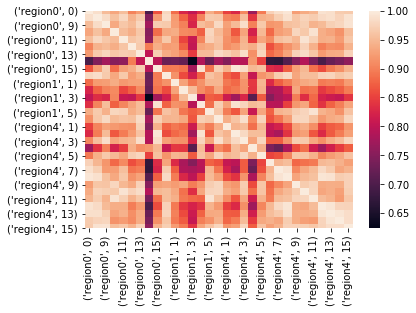

In [111]:
combSpec.plot_consensus_similarity()

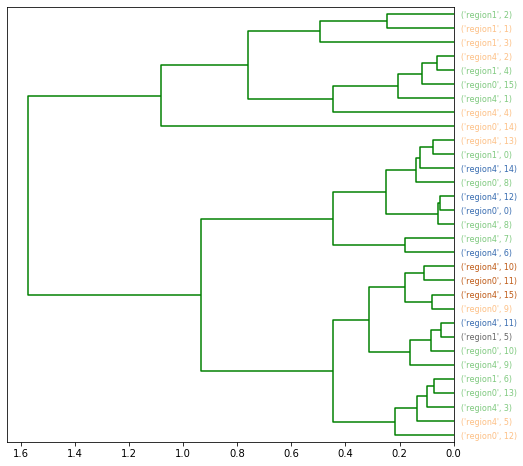

In [122]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

df = combSpec.consensus_similarity_matrix.copy()
# Calculate the distance between each sample
Z = linkage(df.values, 'ward')

plt.figure(figsize=(8,8))
# Make the dendro
dendrogram(Z, labels=df.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')

c = fcluster(Z, t=5, criterion='maxclust')

# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 5)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
df['cat']=pd.Categorical(c)
my_color=df['cat'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))

In [121]:
c

array([2, 2, 1, 1, 1, 1, 1, 5, 3, 2, 4, 4, 4, 3, 1, 1, 3, 3, 1, 3, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 2, 1], dtype=int32)

In [ ]:
combSpec.plot_consensus_dendrogram()

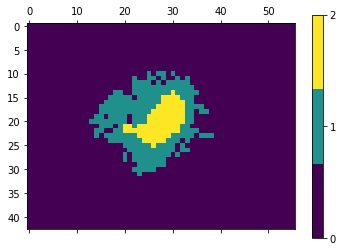

In [81]:
spec1.plot_segments(highlight=(1,2,3))

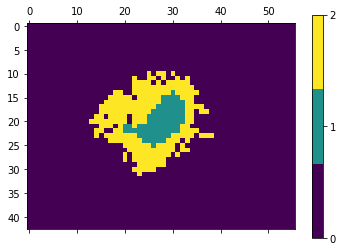

In [82]:
spec1.plot_segments(highlight=(4,5,6))

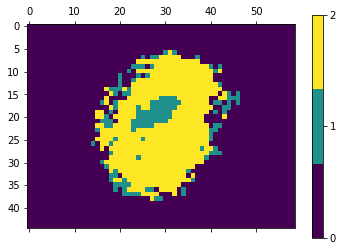

In [85]:
spec.plot_segments(highlight=(9,10,11,13,15))

Found region 4 with shape (49, 56, 17900)
I0616 18:41:53.691322 140009190655808 segment.py:2015] Found region 4 with shape (49, 56, 17900)


3454.87441091502 4
3456.383544128344 198
3457.8926773416683 2539
8421.43181596513 1
4749.710707947227 1
6648.200290309134 1


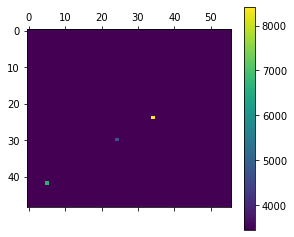

2744 0.13044405 0.4520525 0.332828339705184


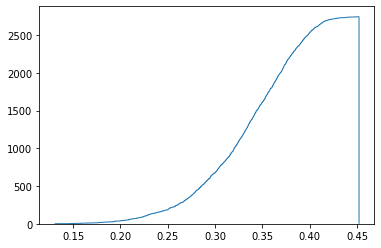

Got spectra (49, 56, 17900)
(49, 56, 17900)


2020-06-16 18:41:56,669  SpectraRegion  INFO: Creating C++ obj
2020-06-16 18:41:56,669  SpectraRegion  INFO: Creating C++ obj
2020-06-16 18:41:56,669  SpectraRegion  INFO: Creating C++ obj
2020-06-16 18:41:56,669  SpectraRegion  INFO: Creating C++ obj
2020-06-16 18:41:56,669  SpectraRegion  INFO: Creating C++ obj
I0616 18:41:56.669112 140009190655808 segment.py:321] Creating C++ obj
2020-06-16 18:41:56,674  SpectraRegion  INFO: dimensions 17900
2020-06-16 18:41:56,674  SpectraRegion  INFO: dimensions 17900
2020-06-16 18:41:56,674  SpectraRegion  INFO: dimensions 17900
2020-06-16 18:41:56,674  SpectraRegion  INFO: dimensions 17900
2020-06-16 18:41:56,674  SpectraRegion  INFO: dimensions 17900
I0616 18:41:56.674998 140009190655808 segment.py:331] dimensions 17900
2020-06-16 18:41:56,679  SpectraRegion  INFO: input dimensions (49, 56, 17900)
2020-06-16 18:41:56,679  SpectraRegion  INFO: input dimensions (49, 56, 17900)
2020-06-16 18:41:56,679  SpectraRegion  INFO: input dimensions (49, 56

(2744, 2744)


2020-06-16 18:46:15,601  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 18:46:15,601  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 18:46:15,601  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 18:46:15,601  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 18:46:15,601  SpectraRegion  INFO: Calculating dist pixel map done
I0616 18:46:15.601667 140009190655808 segment.py:394] Calculating dist pixel map done
2020-06-16 18:46:15,728  SpectraRegion  INFO: Calculating clusters
2020-06-16 18:46:15,728  SpectraRegion  INFO: Calculating clusters
2020-06-16 18:46:15,728  SpectraRegion  INFO: Calculating clusters
2020-06-16 18:46:15,728  SpectraRegion  INFO: Calculating clusters
2020-06-16 18:46:15,728  SpectraRegion  INFO: Calculating clusters
I0616 18:46:15.728252 140009190655808 segment.py:541] Calculating clusters
2020-06-16 18:46:16,098  SpectraRegion  INFO: Calculating clusters done
2020-06-16 18:46:16,098  SpectraRegion  IN

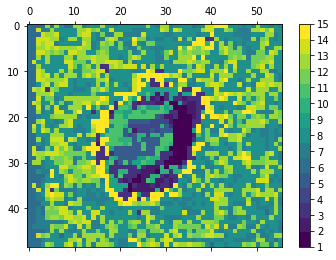

In [93]:
spectra4 = imze.get_region_array(4, makeNullLine=True)
imze.normalize_region_array(spectra4, normalize="vector")
imze.list_highest_peaks(spectra4, counter=True)
print("Got spectra", spectra4.shape)

spec4 = SpectraRegion(spectra4, imze.mzValues)
spec4.calculate_similarity(mode="spectra_log_dist")
spec4.segment(method="WARD", number_of_regions=15)
spec4.plot_segments()

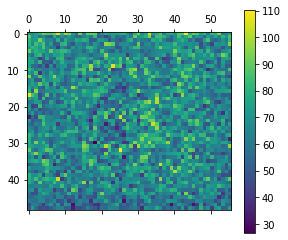

In [92]:
imze.plot_toc(spectra4)

2020-06-16 17:35:20,324  SpectraRegion  INFO: Assigning clusters to background: {9, 10, 11, 12, 13, 14, 15}
2020-06-16 17:35:20,324  SpectraRegion  INFO: Assigning clusters to background: {9, 10, 11, 12, 13, 14, 15}
2020-06-16 17:35:20,324  SpectraRegion  INFO: Assigning clusters to background: {9, 10, 11, 12, 13, 14, 15}
2020-06-16 17:35:20,324  SpectraRegion  INFO: Assigning clusters to background: {9, 10, 11, 12, 13, 14, 15}
I0616 17:35:20.324721 140009190655808 segment.py:663] Assigning clusters to background: {9, 10, 11, 12, 13, 14, 15}


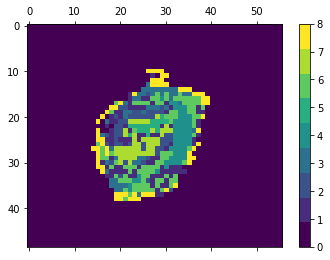

2020-06-16 17:35:20,517  SpectraRegion  INFO: Calculating consensus spectra
2020-06-16 17:35:20,517  SpectraRegion  INFO: Calculating consensus spectra
2020-06-16 17:35:20,517  SpectraRegion  INFO: Calculating consensus spectra
2020-06-16 17:35:20,517  SpectraRegion  INFO: Calculating consensus spectra
I0616 17:35:20.517393 140009190655808 segment.py:717] Calculating consensus spectra
2020-06-16 17:35:20,601  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-16 17:35:20,601  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-16 17:35:20,601  SpectraRegion  INFO: Calculating consensus spectra done
2020-06-16 17:35:20,601  SpectraRegion  INFO: Calculating consensus spectra done
I0616 17:35:20.601498 140009190655808 segment.py:729] Calculating consensus spectra done


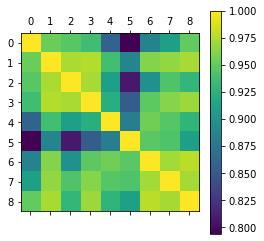

2020-06-16 17:35:20,879  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6, 7, 8]
2020-06-16 17:35:20,879  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6, 7, 8]
2020-06-16 17:35:20,879  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6, 7, 8]
2020-06-16 17:35:20,879  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 6, 7, 8]
I0616 17:35:20.879400 140009190655808 segment.py:847] Found clusterLabels [0, 1, 2, 3, 4, 5, 6, 7, 8]
2020-06-16 17:35:20,885  SpectraRegion  INFO: Processing clusterLabel 0
2020-06-16 17:35:20,885  SpectraRegion  INFO: Processing clusterLabel 0
2020-06-16 17:35:20,885  SpectraRegion  INFO: Processing clusterLabel 0
2020-06-16 17:35:20,885  SpectraRegion  INFO: Processing clusterLabel 0
I0616 17:35:20.885893 140009190655808 segment.py:855] Processing clusterLabel 0
2020-06-16 17:36:09,086  SpectraRegion  INFO: Processing clusterLabel 1
2020-06-16 17:36:09,086  SpectraRegion  INFO: Processing clusterLabel 1
2020-06-16

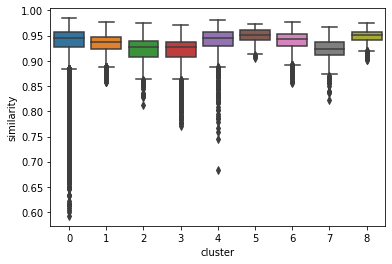

In [88]:
spec4.filter_clusters(method='remove_singleton')
spec4.filter_clusters(method='merge_background')

spec4.filter_clusters(method='remove_islands')
spec4.plot_segments()

spec4.consensus_spectra()
spec4.consensus_similarity()
spec4.plot_consensus_similarity()
spec4.plot_consensus_similarity(mode="spectra")

In [89]:
mgenes4 = spec4.find_all_markers(pw, includeBackground=False, replaceExisting=False, out_prefix="region4", outdirectory="./")

2020-06-16 17:36:12,160  SpectraRegion  INFO: DE data for case: [8]
2020-06-16 17:36:12,160  SpectraRegion  INFO: DE data for case: [8]
2020-06-16 17:36:12,160  SpectraRegion  INFO: DE data for case: [8]
2020-06-16 17:36:12,160  SpectraRegion  INFO: DE data for case: [8]
I0616 17:36:12.160453 140009190655808 segment.py:1286] DE data for case: [8]
2020-06-16 17:36:12,164  SpectraRegion  INFO: DE data for control: [1, 3, 2, 6, 4, 7, 5]
2020-06-16 17:36:12,164  SpectraRegion  INFO: DE data for control: [1, 3, 2, 6, 4, 7, 5]
2020-06-16 17:36:12,164  SpectraRegion  INFO: DE data for control: [1, 3, 2, 6, 4, 7, 5]
2020-06-16 17:36:12,164  SpectraRegion  INFO: DE data for control: [1, 3, 2, 6, 4, 7, 5]
I0616 17:36:12.164853 140009190655808 segment.py:1287] DE data for control: [1, 3, 2, 6, 4, 7, 5]
2020-06-16 17:36:12,170  SpectraRegion  INFO: DE result key: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:36:12,170  SpectraRegion  INFO: DE result key: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:3

Running [8] against [1, 3, 2, 6, 4, 7, 5]


2020-06-16 17:36:12,397  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:36:12,397  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:36:12,397  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:36:12,397  SpectraRegion  INFO: Processing cluster: 6
I0616 17:36:12.397691 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:36:12,476  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:36:12,476  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:36:12,476  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:36:12,476  SpectraRegion  INFO: Processing cluster: 4
I0616 17:36:12.476269 140009190655808 segment.py:1322] Processing cluster: 4
2020-06-16 17:36:12,524  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:36:12,524  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:36:12,524  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:36:12,524  SpectraRegion  INFO: Processing cluster: 7
I0616 17:36:12.524400 14000919

Max condition count (1, 412)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.8.1_2_3_4_5_6_7.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:39:22,198  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:39:22,198  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:39:22,198  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:39:22,198  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:39:22.198639 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.8.1_2_3_4_5_6_7.tsv


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2020-06-16 17:39:22,537  SpectraRegion  INFO: DE-test finished. Results available: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:39:22,537  SpectraRegion  INFO: DE-test finished. Results available: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:39:22,537  SpectraRegion  INFO: DE-test finished. Results available: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:39:22,537  SpectraRegion  INFO: DE-test finished. Results available: ((8,), (1, 2, 3, 4, 5, 6, 7))
I0616 17:39:22.537942 140009190655808 segment.py:1420] DE-test finished. Results available: ((8,), (1, 2, 3, 4, 5, 6, 7))
2020-06-16 17:39:22,585  SpectraRegion  INFO: DE result for case ((8,), (1, 2, 3, 4, 5, 6, 7)) with (17900, 16) results
2020-06-16 17:39:22,585  SpectraRegion  INFO: DE result for case ((8,), (1, 2, 3, 4, 5, 6, 7)) with (17900

Running [1] against [8, 3, 2, 6, 4, 7, 5]


2020-06-16 17:39:30,268  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:39:30,268  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:39:30,268  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:39:30,268  SpectraRegion  INFO: Processing cluster: 6
I0616 17:39:30.268500 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:39:30,354  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:39:30,354  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:39:30,354  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:39:30,354  SpectraRegion  INFO: Processing cluster: 4
I0616 17:39:30.354397 140009190655808 segment.py:1322] Processing cluster: 4
2020-06-16 17:39:30,402  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:39:30,402  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:39:30,402  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:39:30,402  SpectraRegion  INFO: Processing cluster: 7
I0616 17:39:30.402422 14000919

Max condition count (1, 389)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.1.2_3_4_5_6_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:42:41,317  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:42:41,317  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:42:41,317  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:42:41,317  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:42:41.317260 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.1.2_3_4_5_6_7_8.tsv


2020-06-16 17:42:41,660  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6, 7, 8))
2020-06-16 17:42:41,660  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6, 7, 8))
2020-06-16 17:42:41,660  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6, 7, 8))
2020-06-16 17:42:41,660  SpectraRegion  INFO: DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6, 7, 8))
I0616 17:42:41.660825 140009190655808 segment.py:1420] DE-test finished. Results available: ((1,), (2, 3, 4, 5, 6, 7, 8))
2020-06-16 17:42:41,709  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:42:41,709  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:42:41,709  SpectraRegion  INFO: DE result for case ((1,), (2, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:42:41,709  SpectraRegion  INFO: DE result for case (

Running [3] against [8, 1, 2, 6, 4, 7, 5]


2020-06-16 17:42:42,619  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:42:42,619  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:42:42,619  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:42:42,619  SpectraRegion  INFO: Processing cluster: 6
I0616 17:42:42.619877 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:42:42,712  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:42:42,712  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:42:42,712  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:42:42,712  SpectraRegion  INFO: Processing cluster: 4
I0616 17:42:42.712499 140009190655808 segment.py:1322] Processing cluster: 4
2020-06-16 17:42:42,760  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:42:42,760  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:42:42,760  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:42:42,760  SpectraRegion  INFO: Processing cluster: 7
I0616 17:42:42.760409 14000919

Max condition count (1, 429)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.3.1_2_4_5_6_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:46:06,905  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:46:06,905  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:46:06,905  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:46:06,905  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:46:06.905243 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.3.1_2_4_5_6_7_8.tsv


2020-06-16 17:46:07,258  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6, 7, 8))
2020-06-16 17:46:07,258  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6, 7, 8))
2020-06-16 17:46:07,258  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6, 7, 8))
2020-06-16 17:46:07,258  SpectraRegion  INFO: DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6, 7, 8))
I0616 17:46:07.258728 140009190655808 segment.py:1420] DE-test finished. Results available: ((3,), (1, 2, 4, 5, 6, 7, 8))
2020-06-16 17:46:07,311  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:46:07,311  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:46:07,311  SpectraRegion  INFO: DE result for case ((3,), (1, 2, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:46:07,311  SpectraRegion  INFO: DE result for case (

Running [2] against [8, 1, 3, 6, 4, 7, 5]


2020-06-16 17:46:12,836  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:46:12,836  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:46:12,836  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:46:12,836  SpectraRegion  INFO: Processing cluster: 6
I0616 17:46:12.836100 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:46:12,924  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:46:12,924  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:46:12,924  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:46:12,924  SpectraRegion  INFO: Processing cluster: 4
I0616 17:46:12.924554 140009190655808 segment.py:1322] Processing cluster: 4
2020-06-16 17:46:12,969  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:46:12,969  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:46:12,969  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:46:12,969  SpectraRegion  INFO: Processing cluster: 7
I0616 17:46:12.969351 14000919

Max condition count (1, 429)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.2.1_3_4_5_6_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:49:14,156  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:49:14,156  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:49:14,156  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:49:14,156  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:49:14.156417 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.2.1_3_4_5_6_7_8.tsv


2020-06-16 17:49:14,510  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6, 7, 8))
2020-06-16 17:49:14,510  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6, 7, 8))
2020-06-16 17:49:14,510  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6, 7, 8))
2020-06-16 17:49:14,510  SpectraRegion  INFO: DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6, 7, 8))
I0616 17:49:14.510081 140009190655808 segment.py:1420] DE-test finished. Results available: ((2,), (1, 3, 4, 5, 6, 7, 8))
2020-06-16 17:49:14,557  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:49:14,557  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:49:14,557  SpectraRegion  INFO: DE result for case ((2,), (1, 3, 4, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:49:14,557  SpectraRegion  INFO: DE result for case (

Running [6] against [8, 1, 3, 2, 4, 7, 5]


2020-06-16 17:49:31,301  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:49:31,301  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:49:31,301  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:49:31,301  SpectraRegion  INFO: Processing cluster: 2
I0616 17:49:31.301057 140009190655808 segment.py:1322] Processing cluster: 2
2020-06-16 17:49:31,332  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:49:31,332  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:49:31,332  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:49:31,332  SpectraRegion  INFO: Processing cluster: 4
I0616 17:49:31.332766 140009190655808 segment.py:1322] Processing cluster: 4
2020-06-16 17:49:31,376  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:49:31,376  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:49:31,376  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:49:31,376  SpectraRegion  INFO: Processing cluster: 7
I0616 17:49:31.376638 14000919

Max condition count (1, 380)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.6.1_2_3_4_5_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:52:29,912  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:52:29,912  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:52:29,912  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:52:29,912  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:52:29.912887 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.6.1_2_3_4_5_7_8.tsv


2020-06-16 17:52:30,294  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5, 7, 8))
2020-06-16 17:52:30,294  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5, 7, 8))
2020-06-16 17:52:30,294  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5, 7, 8))
2020-06-16 17:52:30,294  SpectraRegion  INFO: DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5, 7, 8))
I0616 17:52:30.294874 140009190655808 segment.py:1420] DE-test finished. Results available: ((6,), (1, 2, 3, 4, 5, 7, 8))
2020-06-16 17:52:30,347  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5, 7, 8)) with (17900, 16) results
2020-06-16 17:52:30,347  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5, 7, 8)) with (17900, 16) results
2020-06-16 17:52:30,347  SpectraRegion  INFO: DE result for case ((6,), (1, 2, 3, 4, 5, 7, 8)) with (17900, 16) results
2020-06-16 17:52:30,347  SpectraRegion  INFO: DE result for case (

Running [4] against [8, 1, 3, 2, 6, 7, 5]


2020-06-16 17:52:33,695  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:52:33,695  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:52:33,695  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:52:33,695  SpectraRegion  INFO: Processing cluster: 6
I0616 17:52:33.695699 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:52:33,761  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:52:33,761  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:52:33,761  SpectraRegion  INFO: Processing cluster: 7
2020-06-16 17:52:33,761  SpectraRegion  INFO: Processing cluster: 7
I0616 17:52:33.761621 140009190655808 segment.py:1322] Processing cluster: 7
2020-06-16 17:52:33,794  SpectraRegion  INFO: Processing cluster: 5
2020-06-16 17:52:33,794  SpectraRegion  INFO: Processing cluster: 5
2020-06-16 17:52:33,794  SpectraRegion  INFO: Processing cluster: 5
2020-06-16 17:52:33,794  SpectraRegion  INFO: Processing cluster: 5
I0616 17:52:33.794024 14000919

Max condition count (1, 422)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.4.1_2_3_5_6_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:55:56,414  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:55:56,414  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:55:56,414  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:55:56,414  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:55:56.414948 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.4.1_2_3_5_6_7_8.tsv


2020-06-16 17:55:56,748  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6, 7, 8))
2020-06-16 17:55:56,748  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6, 7, 8))
2020-06-16 17:55:56,748  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6, 7, 8))
2020-06-16 17:55:56,748  SpectraRegion  INFO: DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6, 7, 8))
I0616 17:55:56.748331 140009190655808 segment.py:1420] DE-test finished. Results available: ((4,), (1, 2, 3, 5, 6, 7, 8))
2020-06-16 17:55:56,801  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:55:56,801  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:55:56,801  SpectraRegion  INFO: DE result for case ((4,), (1, 2, 3, 5, 6, 7, 8)) with (17900, 16) results
2020-06-16 17:55:56,801  SpectraRegion  INFO: DE result for case (

Running [7] against [8, 1, 3, 2, 6, 4, 5]


2020-06-16 17:55:58,518  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:55:58,518  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:55:58,518  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:55:58,518  SpectraRegion  INFO: Processing cluster: 2
I0616 17:55:58.518851 140009190655808 segment.py:1322] Processing cluster: 2
2020-06-16 17:55:58,560  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:55:58,560  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:55:58,560  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:55:58,560  SpectraRegion  INFO: Processing cluster: 6
I0616 17:55:58.560329 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:55:58,645  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:55:58,645  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:55:58,645  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:55:58,645  SpectraRegion  INFO: Processing cluster: 4
I0616 17:55:58.645569 14000919

Max condition count (1, 431)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.7.1_2_3_4_5_6_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 17:59:17,639  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:59:17,639  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:59:17,639  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 17:59:17,639  SpectraRegion  INFO: Performing DE-test: ttest
I0616 17:59:17.639245 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.7.1_2_3_4_5_6_8.tsv


2020-06-16 17:59:17,988  SpectraRegion  INFO: DE-test finished. Results available: ((7,), (1, 2, 3, 4, 5, 6, 8))
2020-06-16 17:59:17,988  SpectraRegion  INFO: DE-test finished. Results available: ((7,), (1, 2, 3, 4, 5, 6, 8))
2020-06-16 17:59:17,988  SpectraRegion  INFO: DE-test finished. Results available: ((7,), (1, 2, 3, 4, 5, 6, 8))
2020-06-16 17:59:17,988  SpectraRegion  INFO: DE-test finished. Results available: ((7,), (1, 2, 3, 4, 5, 6, 8))
I0616 17:59:17.988432 140009190655808 segment.py:1420] DE-test finished. Results available: ((7,), (1, 2, 3, 4, 5, 6, 8))
2020-06-16 17:59:18,043  SpectraRegion  INFO: DE result for case ((7,), (1, 2, 3, 4, 5, 6, 8)) with (17900, 16) results
2020-06-16 17:59:18,043  SpectraRegion  INFO: DE result for case ((7,), (1, 2, 3, 4, 5, 6, 8)) with (17900, 16) results
2020-06-16 17:59:18,043  SpectraRegion  INFO: DE result for case ((7,), (1, 2, 3, 4, 5, 6, 8)) with (17900, 16) results
2020-06-16 17:59:18,043  SpectraRegion  INFO: DE result for case (

Running [5] against [8, 1, 3, 2, 6, 4, 7]


2020-06-16 17:59:21,955  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:59:21,955  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:59:21,955  SpectraRegion  INFO: Processing cluster: 2
2020-06-16 17:59:21,955  SpectraRegion  INFO: Processing cluster: 2
I0616 17:59:21.955005 140009190655808 segment.py:1322] Processing cluster: 2
2020-06-16 17:59:21,990  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:59:21,990  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:59:21,990  SpectraRegion  INFO: Processing cluster: 6
2020-06-16 17:59:21,990  SpectraRegion  INFO: Processing cluster: 6
I0616 17:59:21.990866 140009190655808 segment.py:1322] Processing cluster: 6
2020-06-16 17:59:22,057  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:59:22,057  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:59:22,057  SpectraRegion  INFO: Processing cluster: 4
2020-06-16 17:59:22,057  SpectraRegion  INFO: Processing cluster: 4
I0616 17:59:22.057152 14000919

Max condition count (1, 461)
/usr/bin/java -Xmx24G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -getbestsubN 100 -inputdir ./ -cond1 0 -cond2 1 -o .//exprs_ds.txt
Cmd returned with exit code 0
Writing new Pdata
Writing new exprs data
/usr/bin/java -Xmx16G -cp /mnt/d/dev/git/pyIMS/src/pySRM/pysrm/../../../tools/nlEmpiRe.jar nlEmpiRe.input.ExpressionSet -inputdir ./ -cond1 0 -cond2 1 -o .//region4.5.1_2_3_4_6_7_8.tsv
Cmd returned with exit code 1
1
Exception in thread "main" lmu.utils.FRuntimeException: 1: cannot normalize samples - too many non-overlapping features clustered 50 samples into 2 groups:
	cluster: 1 size: 49 replicates: [cond2.rep1, cond2.rep2, cond2.rep3, cond2.rep4, cond2.rep5, cond2.rep6, cond2.rep7, cond2.rep8, cond2.rep9, cond2.rep10, cond2.rep11, cond2.rep12, cond2.rep13, cond2.rep14, cond2.rep15, cond2.rep16, cond2.rep17, cond2.rep18, cond2.rep19, cond2.rep20, cond2.rep21, cond2.rep22, cond2.rep23, cond2.rep24, con

2020-06-16 18:03:00,670  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 18:03:00,670  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 18:03:00,670  SpectraRegion  INFO: Performing DE-test: ttest
2020-06-16 18:03:00,670  SpectraRegion  INFO: Performing DE-test: ttest
I0616 18:03:00.670173 140009190655808 segment.py:1395] Performing DE-test: ttest


Cmd returned with exit code 0
0
EMPIRE output available: .//region4.5.1_2_3_4_6_7_8.tsv


2020-06-16 18:03:01,066  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8))
2020-06-16 18:03:01,066  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8))
2020-06-16 18:03:01,066  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8))
2020-06-16 18:03:01,066  SpectraRegion  INFO: DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8))
I0616 18:03:01.066037 140009190655808 segment.py:1420] DE-test finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8))
2020-06-16 18:03:01,121  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6, 7, 8)) with (17900, 16) results
2020-06-16 18:03:01,121  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6, 7, 8)) with (17900, 16) results
2020-06-16 18:03:01,121  SpectraRegion  INFO: DE result for case ((5,), (1, 2, 3, 4, 6, 7, 8)) with (17900, 16) results
2020-06-16 18:03:01,121  SpectraRegion  INFO: DE result for case (

In [90]:
markerGenes4 = mgenes4["ttest"]
markerGenes4.to_csv("marker_genes_region_4.tsv", sep="\t", index=False)

In [91]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_4.tsv -n 4

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
1	Hepatic stellate cells;Liver	0.0	1	46	{'RBP1'}
2	Basal cells;Epithelium	0.0	1	56	{'DUSP23'}
2	Basophils;Immune system	0.0	2	82	{'IFITM1', 'IGFBP7'}
2	Cardiomyocytes;Heart	0.0	2	106	{'HAMP', 'TNNC1'}
2	Dendritic cells;Immune system	0.0	1	133	{'LGALS3'}
3	Basophils;Immune system	0.0	1	82	{'IFITM1'}
3	Endothelial cells;Vasculature	0.0	1	195	{'GNG11'}
3	Gamma delta T cells;Immune system	0.0	1	66	{'IFITM1'}
3	Hepatocytes;Liver	0.0	1	154	{'APOA2'}
4	Monocytes;Immune system	0.0	1	102	{'IFITM3'}
5	Platelets;Blood	0.01923820860566426	3	131	{'HIST1H2BC', 'PF4', 'HIST1H2BK'}
5	Hepatic stellate cells;Liver	0.019232762881040973	2	46	{'IGFBP7', 'RBP1'}
5	Monocytes;Immune system	0.012478663043020326	1	102	{'IFITM3'}
5	H